<a href="https://colab.research.google.com/github/Jake-Lockwood/Thermodynamics/blob/main/ThermoWorkBetter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [705]:
!pip install pandas
!pip install thermo

In [706]:
import numpy as np
import thermo
import pandas as pd
import matplotlib.pyplot as plt
from numpy import poly1d
import matplotlib.pylab as plb

def S_IG_TP(a,T,P):
    # returns entropy of ideal gas
    #function S_IG = S_IG(a,T)
    #S_IG returns the entropy of a substance (J/mol K)
    #assuming it is an ideal gas with heat capacity parameters
    #where the vector a is the 4 component vector 
    #listed in Sandler Appendix AII
    #It is from a basis of S = 0 at T=1K and P = 1 Pa.
    #Only use for differences.
    
    #convert to correct values
    R = 8.314
    S_IG_TP = a[0]*np.log(T)+a[1]*1e-2*T + a[2]*T**2*1e-5/2 + a[3]*T**3*1e-9/3 - R*np.log(P)
    #S_IG = a[0]*np.log(T)
    return S_IG_TP

def Cp_star(a,T):
    # returns Cp in J/molK using values from Sandler
    Cp = a[0]+a[1]*1e-2*T + a[2]*T**2*1e-5 + a[3]*T**3*1e-9
    return Cp

def H_IG(a,T):
    # returns H in J/mol of IG using values from sandler
    H_IG = a[0]*T+a[1]*1e-2*T**2/2 + a[2]*T**3*1e-5/3 + a[3]*T**4*1e-9/4
    return H_IG

def cubic_roots(coeff):
    # returns real roots of the cubic equation
    total_roots = np.roots(coeff)
    
    if np.isrealobj(total_roots):
        Z_temp = np.sort(total_roots)
        # have to check if I get a negative value
        # if that is the case then the highest root is correct
        # only happens for PR EOS
        if Z_temp[0] < 0:
            Z = Z_temp[2]
        else:
            Z = Z_temp
            
    else: 
        # we have 1 real root and 2 imaginary roots
        # find real root
        for x in total_roots:
            if np.isreal(x):
                Z = np.real(x)
    
    return Z

def PR_param(P,T,substance):
    # function outputs the PR parameters (a,b,da/dt, A, B) in a vector form
    # param from the inputs P, T, and the substance where the substance is a
    # vector of (Tc, Pc, omega)
    # all values of P and T should be in SI units! (Pa and K)
    R = 8.314
    
    # break out substance
    Tc = substance[0]
    Pc = substance[1]
    omega = substance[2]
    
    # calculate a and b
    b = 0.0778*R*Tc/Pc
    kappa = 0.37464 + 1.54226*omega - 0.26992*omega**2
    alpha = (1+kappa*(1-np.sqrt(T/Tc)))**2
    a = 0.45724* (R*Tc)**2 *alpha/Pc
    dadt = -(0.45724*(R*Tc)**2 *kappa/Pc)*np.sqrt(alpha/(T*Tc))
    
    # calculate A and B
    A = a*P/(R*T)**2
    B = b*P/(R*T)
    
    param = np.array([a, b, dadt, A, B])
    return param

def PR_Z(A,B):
    #PR_Z outputs sorted real roots of cubic PR EOS
    c0 = 1
    c1 = -(1-B)
    c2 = A - 3*B*B - 2*B
    c3 = -(A*B - B*B - B*B*B)
    coeff = np.array([c0, c1, c2, c3])
    
    Z = cubic_roots(coeff)
    return Z

def PR_H(P,T,param,Z):
    # PR_H outputs enthalpy departure function in Joules/mol
    # for the PR EOS
    # Note that Z must be singularly valued!
    R = 8.314
    a = param[0]; b = param[1]; dadt = param[2]
    A = param[3]; B = param[4]
    s2 = np.sqrt(2)
    H = R*T*(Z-1) + ((T*dadt - a)/(2*s2*b))*np.log((Z + (1+s2)*B)/(Z + (1-s2)*B))
    
    return H

def PR_S(P,T,param,Z):
    # PR_S outputs etnropy departure function in J/molK for PR EOS
    # Note that Z must be singuraly valued
    R = 8.314
    a = param[0]; b = param[1]; dadt = param[2]
    A = param[3]; B = param[4]
    s2 = np.sqrt(2)
    S = R*np.log(Z-B)+ (dadt/(2*s2*b))*np.log((Z +(1 +s2)*B)/(Z +(1 -s2)*B))
    
    return S

def PR_log_phi(A,B,Z):
    # outputs the log of the fugacity coefiicient
    # for the PR EOS
    # Z must be singulary valued
    s2 = np.sqrt(2)
    log_phi = (Z-1) - np.log(Z-B) - (A/(2*s2*B))*np.log((Z + (1 +s2)*B)/(Z + (1 -s2)*B))
    
    return log_phi

def PR_log_phi_mix_liq(Av,Bv,x):
    # to get fugacity of mixture, have the components in vector x
    # have the A and B values of each component in vectors Av and Bv
    # 
    C = len(x) # number of components 
    Am = 0
    for i in range(C):
        for j in range(C):
            Am = Am + x[i]*x[j]*np.sqrt(Av[i]*Av[j])
    # now do B
    Bm = 0        
    for i in range(C):
        Bm = Bm + x[i]*Bv[i]
    # get liquid root, Z_l
    # for liquid we want the lowest positive root
    Z = PR_Z(Am,Bm)
    if np.isscalar(Z) == False:
        Z_l = Z[0]
    else:
        Z_l = Z
    # now do the fugacity calculation
    # this is Eq. 9.4-10
    s2 = np.sqrt(2)
    # initialize temp
    temp = np.zeros(len(x))
    log_phi = np.zeros(len(x))
    for i in range(C):
        #
        for j in range(C):
            temp[i] = temp[i] + x[j]*np.sqrt(Av[i]*Av[j])
        log_phi[i]=(Z_l -1)*Bv[i]/Bm - np.log(Z_l - Bm) + (-Am/(Bm*2*s2))*(2*temp[i]/Am - Bv[i]/Bm)*np.log((Z_l + (1+s2)*Bm)/(Z_l + (1-s2)*Bm))
    return log_phi
    
def PR_log_phi_mix_vap(Av,Bv,x):
    # to get fugacity of mixture, have the components in vector x
    # have the A and B values of each component in vectors Av and Bv
    # 
    C = len(x) # number of components 
    Am = 0
    for i in range(C):
        for j in range(C):
            Am = Am + x[i]*x[j]*np.sqrt(Av[i]*Av[j])
    # now do B
    Bm = 0        
    for i in range(C):
        Bm = Bm + x[i]*Bv[i]
    # get liquid root, Z_l
    # for liquid we want the lowest positive root
    Z = PR_Z(Am,Bm)
    if np.isscalar(Z) == False:
        Z_l = Z[2]
    else:
        Z_l = Z
    # now do the fugacity calculation
    # this is Eq. 9.4-10
    s2 = np.sqrt(2)
    # initialize temp
    temp = np.zeros(len(x))
    log_phi = np.zeros(len(x))
    for i in range(C):
        #
        for j in range(C):
            temp[i] = temp[i] + x[j]*np.sqrt(Av[i]*Av[j])
        log_phi[i]=(Z_l -1)*Bv[i]/Bm - np.log(Z_l - Bm) + (-Am/(Bm*2*s2))*(2*temp[i]/Am - Bv[i]/Bm)*np.log((Z_l + (1+s2)*Bm)/(Z_l + (1-s2)*Bm))
    return log_phi
    

In [707]:
df= pd.read_csv("https://raw.githubusercontent.com/Jake-Lockwood/Thermodynamics/main/valuestable.csv", encoding='cp1252')

In [708]:
df.head()

,Substance,Symbol,MolecularWeight,Tc,Pc,Vc,Zc,Omega,Tboil,a,b,c,d,TemperatureRange
0,Acetylene,C2H2,26.038,308.3,6.140,0.113,0.271,0.184,189.2,21.799,9.208,-6.523,18.197,273â€“1500
1,Ammonia,NH3,17.031,405.6,11.280,0.072,0.242,0.250,239.7,27.551,2.563,0.990,-6.687,273â€“1500
2,Benzene,C6H6,78.114,562.1,4.894,0.259,0.271,0.212,353.3,-36.193,48.444,-31.548,77.573,273â€“1500
3,1-Butene,C4H8,56.108,419.6,4.023,0.240,0.277,0.187,266.9,-1.004,36.193,-21.381,50.502,273â€“1500
4,n-butane,C4H10,58.124,425.2,3.800,0.255,0.274,0.300,272.7,3.954,37.126,-18.326,34.979,273â€“1500


In [709]:
homework9 = (np.array([300, 320, 340, 360, 380, 400]), np.array([0.26110125, 0.46105421, 0.75924786, 1.18210221, 1.75860968,
        2.52056083]))

In [710]:
class thermodynamics:
  def __init__(self, substance, T, P):
    self.name = substance
    self.df_sub = df.loc[df['Substance'] == substance]

    self.T = T
    self.P = P

    self.Tc = self.df_sub.iloc[[0], [3]].values[0].item()
    self.Pc = self.df_sub.iloc[[0], [4]].values[0].item()
    self.omega = self.df_sub.iloc[[0], [7]].values[0].item()
    self.a = self.df_sub.iloc[[0], [9]].values[0].item()
    self.b = self.df_sub.iloc[[0], [10]].values[0].item()
    self.c = self.df_sub.iloc[[0], [11]].values[0].item()
    self.d = self.df_sub.iloc[[0], [12]].values[0].item()

    self.R = 8.314

    self.substance_props = np.array([self.Tc, self.Pc, self.omega])

    self.Cp_param = np.array([self.a, self.b, self.c, self.d])

    self.param = PR_param(self.P,self.T,self.substance_props)

    self.A = self.param[3]
    self.B = self.param[4]

    self.Z = PR_Z(self.A,self.B)

  def properties(self):
    r = self.df_sub
    return r

  def enthalpy(self):

    HDEP = PR_H(self.P,self.T,self.param,self.Z)
    H__IG = H_IG(self.Cp_param, self.T)

    H_total = H__IG + HDEP

    return H_total

  def enthalpy_dep(self):
    HDEP = PR_H(self.P,self.T,self.param,self.Z)
    return HDEP

  def enthalpy_dep_z(self, z):
    HDEP = PR_H(self.P,self.T,self.param,z)
    return HDEP

  def enthalpy_CpConst():
    #DOES NOT WORK YET
    HDEP = PR_H(self.P,self.T,self.param,self.Z)
    return

  def entropy(self):
    self.SDEP = PR_S(self.P,self.T,self.param,self.Z) # this is the S departure function
    self.S_IG_TP = S_IG_TP(self.Cp_param, self.T, self.P*1e6)

    self.S_total = self.S_IG_TP + self.SDEP

    return self.S_total

  def entropy_dep_z(self, z):
    SDEP = PR_S(self.P,self.T,self.param,z)
    return SDEP


  def molar_volume(self):
    self.V = self.R*self.T*self.Z/(self.P*1e6) # note this is a molar volume

    return self.V

  def molar_volume_z(self, z):
    V = self.R*self.T*z/(self.P*1e6)
    return V

  def Z_val(self):
    z = PR_Z(self.A, self.B)
    return z

  def PR_phi(self, z):
    if type(z) == int:
      phi = PR_log_phi(self.A, self.B, z)
      return phi
    elif str(type(z)) == "<class 'numpy.ndarray'>":
      phi1 = np.exp(PR_log_phi(self.A, self.B, z[0]))
      phi2 = np.exp(PR_log_phi(self.A, self.B, z[1]))
      phi3 = np.exp(PR_log_phi(self.A, self.B, z[2]))
      return np.array([phi1, phi2, phi3])
    else:
      return "WARNING: Invalid Z-input"


  def sub_state(self):

    return

  def H_constant_P(self, P2, diff):

    H1 = self.enthalpy()
    print("Initial H: " + str(H1))
    for i in range(10000):
      
      param = PR_param(P2,i,self.substance_props)
      A = self.param[3]
      B = self.param[4]

      Z = PR_Z(A,B)

      H_IG_1 = H_IG(self.Cp_param, i)
      H_DEP = PR_H(P2, i, param, Z)
      H2 = H_IG_1 + H_DEP
      
      if H1-diff <= H2 <= H1+diff:
        r = "T: "+str(i)+"  |  Final H: "+str(H2)
        return r

  def H_constant_T(self, T2, diff):
    print("WARNING, THIS FUNCTION HAS NOT BEEN TESTED")
    H1 = self.enthalpy()
    print("Initial H: " + str(H1))
    for i in range(10000):
      
      k=i/100 #shrink iteration

      param = PR_param(k,T2,self.substance_props)
      A = self.param[3]
      B = self.param[4]

      Z = PR_Z(A,B)

      H_IG_1 = H_IG(self.Cp_param, T2)
      H_DEP = PR_H(k, T2, param, Z)
      H2 = H_IG_1 + H_DEP
      if H1-diff <= H2 <= H1+diff:
        r = "P: "+str(k)+"  |  Final H: "+str(H2)
        return r


  def S_constant_P(self, P2, diff):

    S1 = self.entropy()
    print("Initial S: " + str(S1))
    for i in range(10000):
      param = PR_param(P2,i,self.substance_props)
      A = self.param[3]
      B = self.param[4]

      Z = PR_Z(A,B)

      SDEP = PR_S(P2,i,param,Z) # this is the S departure function
      S_IG_TP_F = S_IG_TP(self.Cp_param, i, P2*1e6)
      S2 = SDEP + S_IG_TP_F
      if S1-diff <= S2 <= S1+diff:
        r = "T: "+str(i)+"  |  Final S: "+str(S2)
        return r

  def S_constant_T(self, T2, diff):

    S1 = self.entropy()
    print("Initial S: " + str(S1))
    for i in range(10000):

      k=i/100
      param = PR_param(k,T2,self.substance_props)
      A = self.param[3]
      B = self.param[4]

      Z = PR_Z(A,B)

      SDEP = PR_S(k,T2,param,Z) # this is the S departure function
      S_IG_TP_F = S_IG_TP(self.Cp_param, T2, k*1e6)
      S2 = SDEP + S_IG_TP_F
      if S1-diff <= S2 <= S1+diff:
        r = "P: "+str(k)+"  |  Final S: "+str(S2)
        return r


  def PR_Vapor(self, T, P_vap_guess): #Tc, Pc, and omega come from class instantiation
    P = P_vap_guess
    param = PR_param(P,T,self.substance_props) #initalize all parameters
    A = param[3]
    B = param[4]
    Zs = PR_Z(A, B)
    if str(type(Zs)) == "<class 'numpy.float64'>": #make sure Z has 3 roots
      return "SINGLE Z ROOT"
    else:
      Z_low = Zs[0]
      Z_high = Zs[2]
      fl = np.exp(PR_log_phi(A, B, Z_low))
      fv = np.exp(PR_log_phi(A, B, Z_high))

      while (abs(fl/fv-1)) > 0.0001: #loop over P-guess until condition met
        A = param[3]
        B = param[4]
        Zs = PR_Z(A, B)
        if str(type(Zs)) == "<class 'numpy.float64'>":  #make sure Z has 3 roots
          return "SINGLE Z ROOT"
        else:
          Z_low = Zs[0]
          Z_high = Zs[2]
          fl = np.exp(PR_log_phi(A, B, Z_low))
          fv = np.exp(PR_log_phi(A, B, Z_high))
          P = P*fl/fv         #new P vapor guess
          param = PR_param(P, T, self.substance_props)

    return P #return vapor pressure

  def vapor_data_collection(self):
    n = int(input("number of temperature entries "))
    temps = np.array([])
    for i in range(n):
      #temps.append(input(T+str(i+1)))
      temps = np.append(temps, int(input("T"+str(i+1)+" ")))

    vapor_pressures = np.array([])
    for i in range(n):
      vap = self.PR_Vapor(temps[i], float(input("P vap guess ")))
      if vap == "SINGLE Z ROOT":
        for j in range(100):
          vap = self.PR_Vapor(temps[i], float(input("Bad guess, enter new P vap guess ")))
          if vap != "SINGLE Z ROOT":
            break
        vapor_pressures = np.append(vapor_pressures, vap)
      else:
        vapor_pressures = np.append(vapor_pressures, vap)

    return temps, vapor_pressures

  def vapor_plot(self):
    if input("Use HW numbers, yes or no ") == "yes":
      data = homework9
      temps = data[0]
      vapor_pressures = data[1]
      x = temps
      x_1 = 1000/x
      y = vapor_pressures
      y_1 = np.log(vapor_pressures)
      plt.scatter(x, y)
      z = np.polyfit(x, y, 4)
      p = np.poly1d(z)
      plb.plot(x, p(x), 'm-')
      plt.title("Vapor Pressure for "+self.name)
      plt.xlabel("Temperature (K)")
      plt.ylabel("Pressure (MPa)")
      plt.grid()

      plt.show()
    else:
      data = self.vapor_data_collection()
      temps = data[0]
      vapor_pressures = data[1]
      x = temps
      x_1 = 1000/x
      y = vapor_pressures
      y_1 = np.log(vapor_pressures)
      plt.scatter(x, y)
      z = np.polyfit(x, y, 4)
      p = np.poly1d(z)
      plb.plot(x, p(x), 'm-')
      plt.title("Vapor Pressure for "+self.name)
      plt.xlabel("Temperature (K)")
      plt.ylabel("Pressure (MPa)")
      plt.grid()

      plt.show()

  def vapor_plot_semilog(self):
    if input("Use HW numbers, yes or no ") == "yes":
      data = homework9
      temps = data[0]
      vapor_pressures = data[1]
      x = temps
      x_1 = 1000/x
      y = vapor_pressures
      y_1 = np.log(vapor_pressures)
      plt.scatter(x, y_1)
      z = np.polyfit(x, y_1, 4)
      p = np.poly1d(z)
      plb.plot(x, p(x), 'm-')
      plt.title("Vapor Pressure for "+self.name)
      plt.xlabel("Temperature (K)")
      plt.ylabel("Natural log of Pressure (MPa)")
      plt.grid()

      plt.show()
    else: 
      data = self.vapor_data_collection()
      temps = data[0]
      vapor_pressures = data[1]
      x = temps
      x_1 = 1000/x
      y = vapor_pressures
      y_1 = np.log(vapor_pressures)
      plt.scatter(x, y_1)
      z = np.polyfit(x, y_1, 4)
      p = np.poly1d(z)
      plb.plot(x, p(x), 'm-')
      plt.title("Vapor Pressure for "+self.name)
      plt.xlabel("Temperature (K)")
      plt.ylabel("Natural log of Pressure (MPa)")
      plt.grid()

      plt.show()

  def vapor_plot_semilog_1000(self):
    if input("Use HW numbers, yes or no ") == "yes":
      data = homework9
      temps = data[0]
      vapor_pressures = data[1]
      x = temps
      x_1 = 1000/x
      y = vapor_pressures
      y_1 = np.log(vapor_pressures)
      plt.scatter(x_1, y_1)
      z = np.polyfit(x_1, y_1, 4)
      p = np.poly1d(z)
      plb.plot(x_1, p(x_1), 'm-')
      plt.title("Vapor Pressure for "+self.name)
      plt.xlabel("1000/Temperature (K)")
      plt.ylabel("Natural log of Pressure (MPa)")
      plt.grid()

      plt.show() 

    else:
      data = self.vapor_data_collection()
      temps = data[0]
      vapor_pressures = data[1]
      x = temps
      x_1 = 1000/x
      y = vapor_pressures
      y_1 = np.log(vapor_pressures)
      plt.scatter(x_1, y_1)
      z = np.polyfit(x_1, y_1, 4)
      p = np.poly1d(z)
      plb.plot(x_1, p(x_1), 'm-')
      plt.title("Vapor Pressure for "+self.name)
      plt.xlabel("1000/Temperature (K)")
      plt.ylabel("Natural log of Pressure (MPa)")
      plt.grid()

      plt.show() 
      




In [711]:
a = thermodynamics("n-butane", 220, 0.3)

In [712]:
a.PR_phi(a.Z_val())

array([0.01478722, 0.91467443, 0.80783212])

Use HW numbers, yes or no no
number of tempature entries 6
T1 300
T2 320
T3 340
T4 360
T5 380
T6 400
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 2


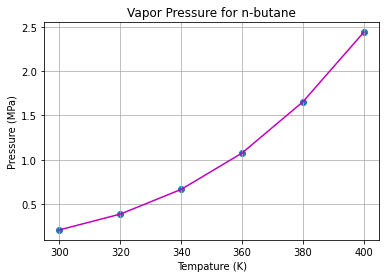

In [715]:
a.vapor_plot()

Use HW numbers, yes or no no
number of tempature entries 6
T1 300
T2 320
T3 340
T4 360
T5 380
T6 400
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 2


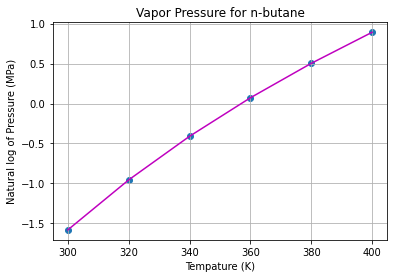

In [716]:
a.vapor_plot_semilog()

Use HW numbers, yes or no no
number of tempature entries 6
T1 300
T2 320
T3 340
T4 360
T5 380
T6 400
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
P vap guess 0.2
Bad guess, enter new P vap guess 2


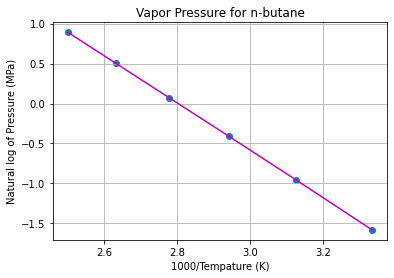

In [717]:
a.vapor_plot_semilog_1000()

In [ ]:
a.vapor_plot()

In [ ]:
a.vapor_data_collection()

In [ ]:
0g

In [ ]:
b = thermodynamics("n-butane", 400, 0.3)

In [ ]:
23555
5str(type(b.Z_val()))

In [ ]:
a.PR_Vapor(400, 1.8)

In [ ]:
vvv = a.Z_val()

In [ ]:
print(a.molar_volume_z(0.01387669))
print(a.enthalpy_dep_z(0.01387669))
print(a.entropy_dep_z(0.01387669))

In [ ]:
str(type(vvv))

In [ ]:
a.PR_phi(vvv)

In [ ]:
b = thermodynamics("Oxygen", 137, 1)

In [ ]:
b.enthalpy()

In [ ]:
test = thermodynamics("Carbon dioxide", 313, 20)

In [ ]:
test.enthalpy()

In [ ]:
test2 = thermodynamics("Carbon dioxide", 307.575, 14)

In [ ]:
test2.enthalpy()

In [ ]:
test.H_constant_P(14, 14)

In [ ]:
#test = thermodynamics("Carbon dioxide", 300, 3)

In [ ]:
#test2 = thermodynamics("Carbon dioxide", 403, 10)

In [ ]:
#test.entropy()

In [ ]:
#test2.entropy()

In [ ]:
#test.S_constant_P(10, 0.05)

In [ ]:
#p = thermodynamics("Oxygen", 300, 8)

In [ ]:
#p.entropy()

In [ ]:
#bb = thermodynamics("Propane", 480, 12.75)

In [ ]:
#bb.molar_volume()

In [ ]:
#test.properties()

In [ ]:
#test.enthalpy()

In [ ]:
#test.entropy()

In [ ]:

#test.molar_volume()

In [ ]:
#test.enthalpy_dep()

In [ ]:
#test.S_constant_P(10, 0.1)

In [ ]:
#test.H_constant_T(403, 10)

In [ ]:
#a = thermodynamics("Carbon dioxide", 403, 10)

In [ ]:
#a.enthalpy()

In [ ]:
#test.enthalpy()

In [ ]:
#test.entropy()

In [ ]:
#a.entropy()

In [ ]:
#test.S_constant_T(403, 0.005)

In [ ]:
#b = thermodynamics("Carbon dioxide", 333, 10)

In [ ]:
#b.H_constant_P(9, 5)

In [ ]:
a = np.array([1, 2, 3])

In [ ]:
np.shape(a)